Intertemporal Arbitrage Strategy

In [ ]:
pip install akshare

In [3]:
import akshare as ak
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MultipleLocator

# Get Data


In [ ]:

class FuturesDataFetcher:
    def __init__(self, symbol, period='daily', start_date=None, end_date=None):
        """
        Initialize futures data fetcher class

        Parameters:
        symbol: str - Futures product name (e.g., "Corn Main Contract")
        period: str - Data frequency, default is 'daily' (daily data)
        start_date: str - Start date, format 'YYYYMMDD'
        end_date: str - End date, format 'YYYYMMDD'
        """
        self.symbol = symbol
        self.period = period
        self.start_date = start_date
        self.end_date = end_date

    def fetch_data(self):
        """
        Fetch futures historical data

        Returns:
        pd.DataFrame - Retrieved futures historical data
        """
        try:
            df = ak.futures_hist_em(
                symbol=self.symbol,
                period=self.period,
                start_date=self.start_date,
                end_date=self.end_date
            )
            return df
        except Exception as e:
            print(f"Failed to fetch data: {e}")
            return None

    def save_to_pickle(self, df, file_path):
        """
        Save data to pickle file

        Parameters:
        df: pd.DataFrame - Data to be saved
        file_path: str - Save path
        """
        try:
            df.to_pickle(file_path)
            print(f"Data successfully saved to {file_path}")
        except Exception as e:
            print(f"Failed to save data: {e}")

In [ ]:
if __name__ == "__main__":
    # Create data fetcher instance
    data_fetcher = FuturesDataFetcher(
        symbol="玉米主连",
        period="daily",
        start_date="20200101",
        end_date="20250717"
    )

    # Fetch data
    futures_data = data_fetcher.fetch_data()

    if futures_data is not None:
        # Save data
        data_fetcher.save_to_pickle(futures_data, f'{data_fetcher.symbol}_{data_fetcher.period}_data.pkl')
        print("Data retrieval and saving completed!")
    else:
        print("Failed to retrieve data")

In [ ]:
#contract information
# Contract multipliers and fee information for various products
futures_fees_info_df = ak.futures_fees_info()
futures_fees_info_df.to_pickle('futures_fees_info.pkl')

# Historical main contract and spot price information
futures_spot_price_daily_df = ak.futures_spot_price_daily(start_day="20200101", end_day="20250703", vars_list=["C"])
futures_spot_price_daily_df.to_pickle('basis_tracking.pkl')

# Data Analysis

In [4]:
# 1. Read data
main = pd.read_pickle('/content/Corn_Main_daily_data.pkl')
second = pd.read_pickle('/content/Corn_Secondary_daily_data.pkl')

# 2. Data processing - Ensure date index alignment
# Convert date format and set as index
main['时间'] = pd.to_datetime(main['时间'])
second['时间'] = pd.to_datetime(second['时间'])

# Set date as index and sort by date
main.set_index('时间', inplace=True)
second.set_index('时间', inplace=True)
main.sort_index(inplace=True)
second.sort_index(inplace=True)

# Filter data from 2024 onwards
# main = main[main.index.year >= 2024]
# second = second[second.index.year >= 2024]

# Align data from both contracts (take intersection of dates)
common_dates = main.index.intersection(second.index)
main = main.loc[common_dates]
second = second.loc[common_dates]

# 3. Calculate spread
spread = main['开盘'] - second['开盘']
spread_mean = spread.mean()
spread_std = spread.std()

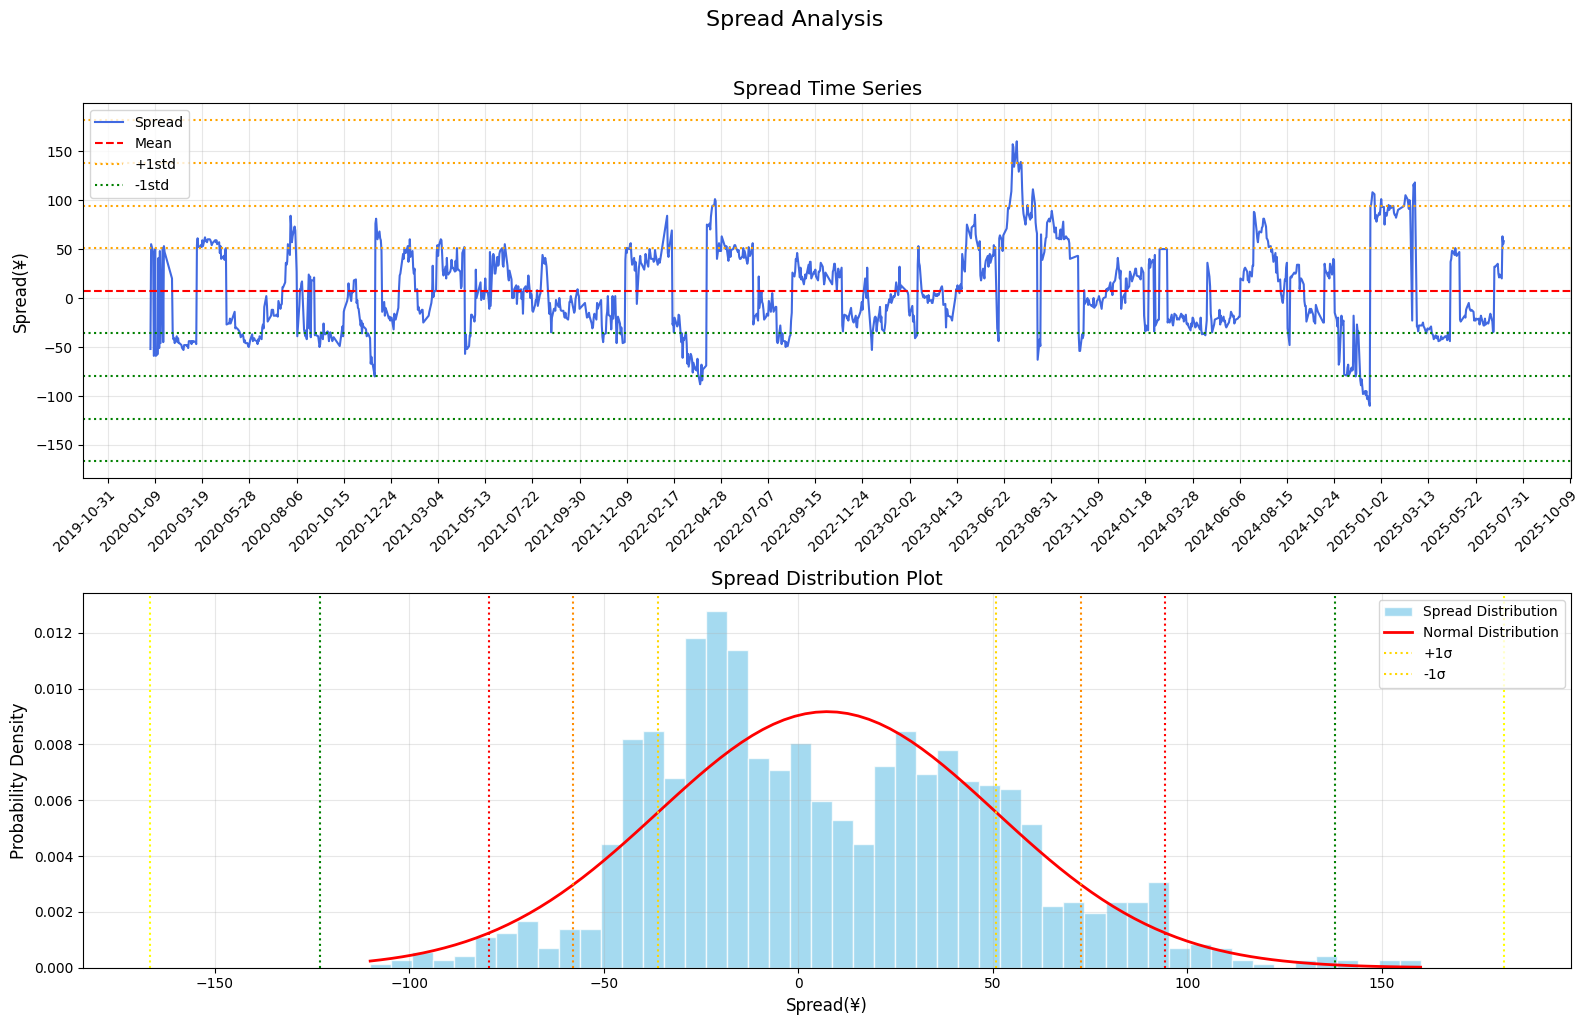

Spread Statistics:
Mean: 7.45
Standard Deviation: 43.48
Maximum: 160.00 (3.5σ)
Minimum: -110.00 (-2.7σ)


In [5]:
# 4. Create canvas
plt.figure(figsize=(16, 10))
plt.suptitle('Spread Analysis', fontsize=16, y=1.02)

# 5. Spread time series plot
ax1 = plt.subplot(2, 1, 1)
ax1.plot(spread.index, spread, label='Spread', color='royalblue', linewidth=1.5)
ax1.axhline(spread_mean, color='red', linestyle='--', label='Mean')
for n in [1,2,3,4]:
    ax1.axhline(spread_mean + n*spread_std, color='orange', linestyle=':',
               label=f'+{n}std' if n==1 else '')
    ax1.axhline(spread_mean - n*spread_std, color='green', linestyle=':',
               label=f'-{n}std' if n==1 else '')

ax1.set_title('Spread Time Series', fontsize=14)
ax1.set_ylabel('Spread(¥)', fontsize=12)
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.xaxis.set_major_locator(MultipleLocator(70))  # One tick every 70 days
# Rotate x-axis labels and adjust format
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

# 6. Spread distribution plot
ax2 = plt.subplot(2, 1, 2)
n, bins, patches = ax2.hist(spread, bins=50, color='skyblue', edgecolor='white',
                           density=True, alpha=0.75, label='Spread Distribution')

# Add normal distribution curve
from scipy.stats import norm
x = np.linspace(spread.min(), spread.max(), 100)
ax2.plot(x, norm.pdf(x, spread_mean, spread_std), 'r-', lw=2, label='Normal Distribution')

# Mark standard deviation positions
colors = ['gold', 'darkorange', 'red','green','yellow']
for i, n in enumerate([1,1.5,2,3,4]):
    ax2.axvline(spread_mean + n*spread_std, color=colors[i], linestyle=':',
               label=f'+{n}σ' if i==0 else '')
    ax2.axvline(spread_mean - n*spread_std, color=colors[i], linestyle=':',
               label=f'-{n}σ' if i==0 else '')

ax2.set_title('Spread Distribution Plot', fontsize=14)
ax2.set_xlabel('Spread(¥)', fontsize=12)
ax2.set_ylabel('Probability Density', fontsize=12)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 7. Output statistical information
print(f"Spread Statistics:")
print(f"Mean: {spread_mean:.2f}")
print(f"Standard Deviation: {spread_std:.2f}")
print(f"Maximum: {spread.max():.2f} ({(spread.max()-spread_mean)/spread_std:.1f}σ)")
print(f"Minimum: {spread.min():.2f} ({(spread.min()-spread_mean)/spread_std:.1f}σ)")

#Strategy

In [6]:
# Calculate thresholds
def cal_trade_threshold(factor, in_sig, out_sig, stop_loss_ratio):
    # Calculate thresholds
    mean = factor.mean()
    std = factor.std()
    ## long and short refer to going long/short on the spread
    long_open = mean + in_sig * std
    long_close = mean - out_sig * std
    short_open = mean - in_sig * std
    short_close = mean + out_sig * std

    # Calculate stop loss thresholds
    long_stop_loss = long_open + 30
    short_stop_loss = short_open - 30

    return long_open, long_close, short_open, short_close, long_stop_loss, short_stop_loss

In [8]:
factor = spread
long_open, long_close, short_open, short_close, long_stop_loss, short_stop_loss = cal_trade_threshold(factor, 2, 0, 0.2)

# Initialize position array
pos_arr = np.zeros(len(factor))

# Trading logic
for idx in range(len(factor)):
    if idx == 0:  # Prevent index out of bounds
        pos_arr[idx] = 0
    elif (pos_arr[idx - 1] == 0) and (factor[idx] > long_open):
        pos_arr[idx] = 1
    elif (pos_arr[idx - 1] == 0) and (factor[idx] < short_open):
        pos_arr[idx] = -1
    elif (pos_arr[idx - 1] > 0) and (factor[idx] < long_close):
        pos_arr[idx] = 0
    elif (pos_arr[idx - 1] < 0) and (factor[idx] > short_close):
        pos_arr[idx] = 0
    elif (pos_arr[idx - 1] > 0) and (factor[idx] > long_stop_loss):  # Long position stop loss
        pos_arr[idx] = 0
    elif (pos_arr[idx - 1] < 0) and (factor[idx] < short_stop_loss):  # Short position stop loss
        pos_arr[idx] = 0
    else:
        pos_arr[idx] = pos_arr[idx - 1]

/tmp/ipython-input-1348377338.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif (pos_arr[idx - 1] == 0) and (factor[idx] > long_open):
/tmp/ipython-input-1348377338.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif (pos_arr[idx - 1] == 0) and (factor[idx] < short_open):
/tmp/ipython-input-1348377338.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif (pos_arr[idx - 1] < 0) and (factor[idx] > short_close):
/tmp/

#Trade

In [9]:
import numpy as np

# Assume the following variables are already defined
# factor: factor series
# near_month_price: near month contract price series
# far_month_price: far month contract price series
# trade_dates: trading date series
# pos_arr: position series

near_month_price = main['开盘']
far_month_price = second['开盘']
trade_dates = common_dates

# Set slippage to 1 tick, the minimum price movement unit for corn futures is 1 yuan
slippage = 1

# # Contract multiplier
# contract_multiplier = 10

# Initialize trade order list
trade_orders = []

# Iterate through position series for trade matching
for idx in range(1, len(pos_arr)):
    # Current date
    current_date = trade_dates[idx]
    # Current position
    current_pos = pos_arr[idx]
    # Previous position
    last_pos = pos_arr[idx - 1]

    # Determine trade type
    if current_pos == 1 and last_pos == 0:  # Open long position (short spread)
        # Sell near month contract, buy far month contract
        near_month_sell_price = near_month_price[idx] - slippage  # Consider slippage
        far_month_buy_price = far_month_price[idx] + slippage  # Consider slippage
        trade_orders.append({
            'date': current_date,
            'action': 'Open short Spread',
            'near_month_price': near_month_sell_price,
            'far_month_price': far_month_buy_price,
            'spread': spread[idx]
        })
    elif current_pos == 0 and last_pos == 1:  # Close long position
        # Buy near month contract, sell far month contract
        near_month_buy_price = near_month_price[idx] + slippage  # Consider slippage
        far_month_sell_price = far_month_price[idx] - slippage  # Consider slippage
        trade_orders.append({
            'date': current_date,
            'action': 'Close short Spread',
            'near_month_price': near_month_buy_price,
            'far_month_price': far_month_sell_price,
            'spread': spread[idx]
        })
    elif current_pos == -1 and last_pos == 0:  # Open short position (long spread)
        # Buy near month contract, sell far month contract
        near_month_buy_price = near_month_price[idx] + slippage  # Consider slippage
        far_month_sell_price = far_month_price[idx] - slippage  # Consider slippage
        trade_orders.append({
            'date': current_date,
            'action': 'Open long Spread',
            'near_month_price': near_month_buy_price,
            'far_month_price': far_month_sell_price,
            'spread': spread[idx]
        })
    elif current_pos == 0 and last_pos == -1:  # Close short position
        # Sell near month contract, buy far month contract
        near_month_sell_price = near_month_price[idx] - slippage  # Consider slippage
        far_month_buy_price = far_month_price[idx] + slippage  # Consider slippage
        trade_orders.append({
            'date': current_date,
            'action': 'Close long Spread',
            'near_month_price': near_month_sell_price,
            'far_month_price': far_month_buy_price,
            'spread': spread[idx]
        })

/tmp/ipython-input-7528695.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  near_month_buy_price = near_month_price[idx] + slippage  # Consider slippage
/tmp/ipython-input-7528695.py:58: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  far_month_sell_price = far_month_price[idx] - slippage  # Consider slippage
/tmp/ipython-input-7528695.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'spread': spread[idx]
/tmp/ipython-input-75

In [11]:
trade_orders = pd.DataFrame(trade_orders)

#Strategy Analysis

In [13]:
import pandas as pd

# Assume the following variables are already defined
# df: DataFrame containing trade records
# df columns include:
#   - 'date': trade date
#   - 'action': trade action (e.g., 'Open Long Spread', 'Close Long Spread', etc.)
#   - 'near_month_price': near month contract price
#   - 'far_month_price': far month contract price
#   - 'order': trade quantity (positive for buy, negative for sell)

# Fixed commission
# Corn 1.51, Peanut 4.01
fixed_commission = 1.51  # Unit: yuan per contract

# Contract multiplier
contract_multiplier = 10

# Function to calculate trade PnL
def calculate_trade_pnl(df, fixed_commission, contract_multiplier):
    # Initialize PnL columns
    df['pnl'] = 0
    df['fee'] = 0
    df['pnl_bf'] = 0  # Pre-fee PnL

    # Iterate through DataFrame to calculate PnL for each trade
    for idx, row in df.iterrows():
        if row['action'] == 'Open short Spread':
            # Open long position (short spread)
            # Sell near month contract, buy far month contract
            df.loc[idx, 'pnl_bf'] = (-row['far_month_price'] + row['near_month_price']) * contract_multiplier
        elif row['action'] == 'Close short Spread':
            # Close long position
            # Buy near month contract, sell far month contract
            df.loc[idx, 'pnl_bf'] = (-row['near_month_price'] + row['far_month_price']) * contract_multiplier
        elif row['action'] == 'Open long Spread':
            # Open short position (long spread)
            # Buy near month contract, sell far month contract
            df.loc[idx, 'pnl_bf'] = (-row['near_month_price'] + row['far_month_price']) * contract_multiplier
        elif row['action'] == 'Close long Spread':
            # Close short position
            # Sell near month contract, buy far month contract
            df.loc[idx, 'pnl_bf'] = (-row['far_month_price'] + row['near_month_price']) * contract_multiplier

        # Calculate commission fee
        df.loc[idx, 'fee'] = 2 * fixed_commission

        # Calculate post-fee PnL
        df.loc[idx, 'pnl'] = df.loc[idx, 'pnl_bf'] - df.loc[idx, 'fee']

    return df

# Calculate trade PnL
df = calculate_trade_pnl(trade_orders, fixed_commission, contract_multiplier)

/tmp/ipython-input-1428402352.py:46: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.02' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[idx, 'fee'] = 2 * fixed_commission
/tmp/ipython-input-1428402352.py:49: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '776.98' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[idx, 'pnl'] = df.loc[idx, 'pnl_bf'] - df.loc[idx, 'fee']


pnl analyze

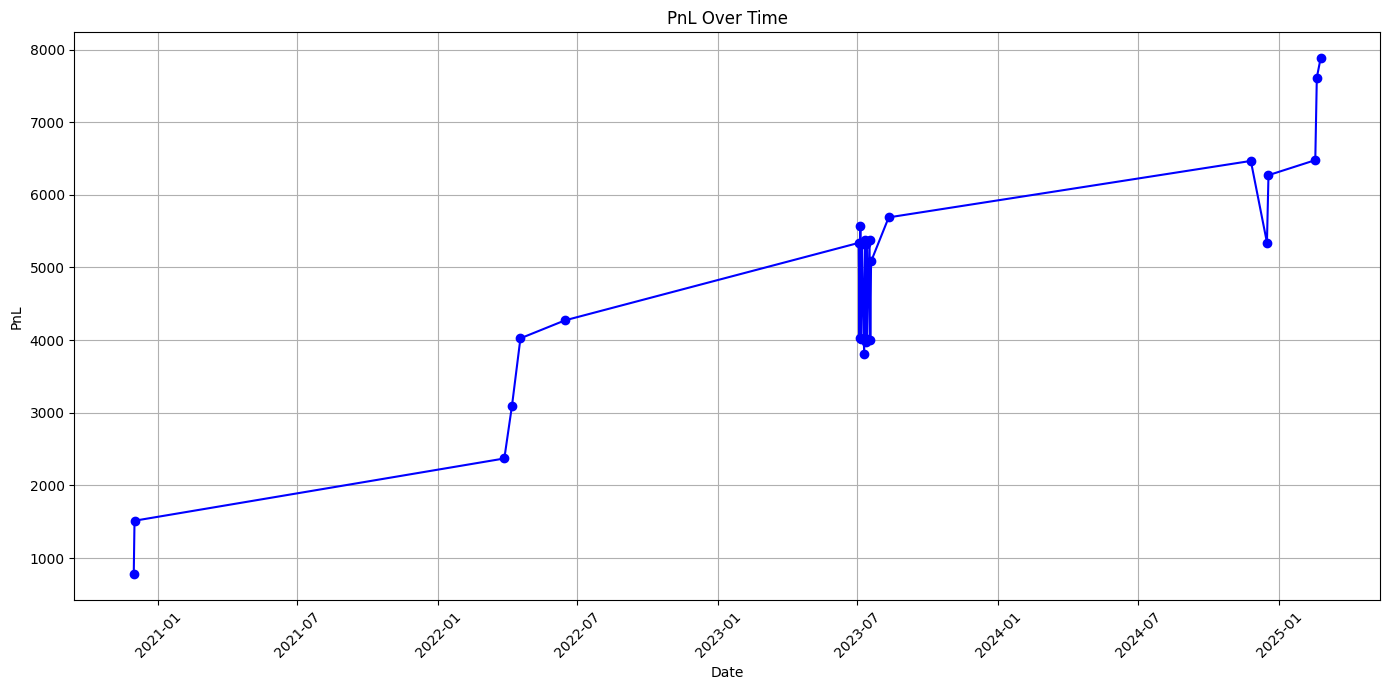

In [14]:
import matplotlib.pyplot as plt

# Ensure date column is datetime type
df['date'] = pd.to_datetime(df['date'])

# Sort by date
df.sort_values(by='date', inplace=True)

# Plot PnL curve
plt.figure(figsize=(14, 7))
plt.plot(df['date'], df['pnl'].cumsum(), marker='o', linestyle='-', color='b')
plt.title('PnL Over Time')
plt.xlabel('Date')
plt.ylabel('PnL')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [15]:
import pandas as pd

# Initialize variables
open_actions = ['Open short Spread', 'Open long Spread']
close_actions = ['Close short Spread', 'Close long Spread']
open_trades = []
close_trades = []
trades_details = []  # Used to store detailed information for each round-trip trade
win_count = 0
total_count = 0
total_profit = 0  # Total profit
total_loss = 0  # Total loss

# Iterate through DataFrame to find matching open and close trades
for i, row in trade_orders.iterrows():
    if row['action'] in open_actions:
        open_trades.append((row['date'], row['pnl'], row['spread']))  # Add record of opening spread
    elif row['action'] in close_actions:
        close_trades.append((row['date'], row['pnl'], row['spread']))  # Add record of closing spread

# Match open and close trades
while open_trades and close_trades:
    open_date, open_pnl, open_spread = open_trades.pop(0)
    close_date, close_pnl, close_spread = close_trades.pop(0)

    if open_date <= close_date:
        total_pnl = close_pnl + open_pnl
        total_count += 1
        if total_pnl > 0:
            win_count += 1
            total_profit += total_pnl  # Accumulate profit
        else:
            total_loss += total_pnl  # Accumulate loss

        # Calculate holding period
        holding_period = (close_date - open_date).days

        # Record detailed information for each round-trip trade
        trades_details.append({
            'Start Date': open_date,
            'Holding Period (days)': holding_period,
            'Open Spread': open_spread,
            'Close Spread': close_spread,
            'Total PnL': total_pnl
        })
    else:
        print(f"Error: Open date {open_date} is after close date {close_date}")

# Calculate win rate
win_rate = win_count / total_count if total_count > 0 else 0

# Calculate profit-loss ratio
profit_loss_ratio = abs(total_profit / total_loss) if total_loss != 0 else float('inf')

# Calculate absolute return per trade (using capital of 3000)
capital = 3000
absolute_returns = [detail['Total PnL'] / capital for detail in trades_details]

# Create merged DataFrame
trades_summary_df = pd.DataFrame(trades_details)
trades_summary_df['Absolute Return'] = absolute_returns

# Output statistical results
print(f"Total trades: {total_count}")
print(f"Winning trades: {win_count}")
print(f"Win rate: {win_rate:.2%}")
print(f"Profit-Loss Ratio: {profit_loss_ratio:.2f}")

# Output merged DataFrame
print("\nTrades Summary:")
print(trades_summary_df)

Total trades: 13
Winning trades: 8
Win rate: 61.54%
Profit-Loss Ratio: 10.49

Trades Summary:
   Start Date  Holding Period (days)  Open Spread  Close Spread  Total PnL  \
0  2020-11-30                      1          -80            76    1513.96   
1  2022-03-28                     10          -88            75    1583.96   
2  2022-04-18                     58           95           -27    1173.96   
3  2023-07-03                      1          109           129    -246.04   
4  2023-07-05                      1          157           154     -16.04   
5  2023-07-07                      3          134           150    -206.04   
6  2023-07-11                      1          160           139     163.96   
7  2023-07-13                      1          138           129      43.96   
8  2023-07-17                      1          139           136     -16.04   
9  2023-07-19                     23          111           -63    1693.96   
10 2024-11-25                     21          -8

holding time analyze

Average Holding Days: 14.38


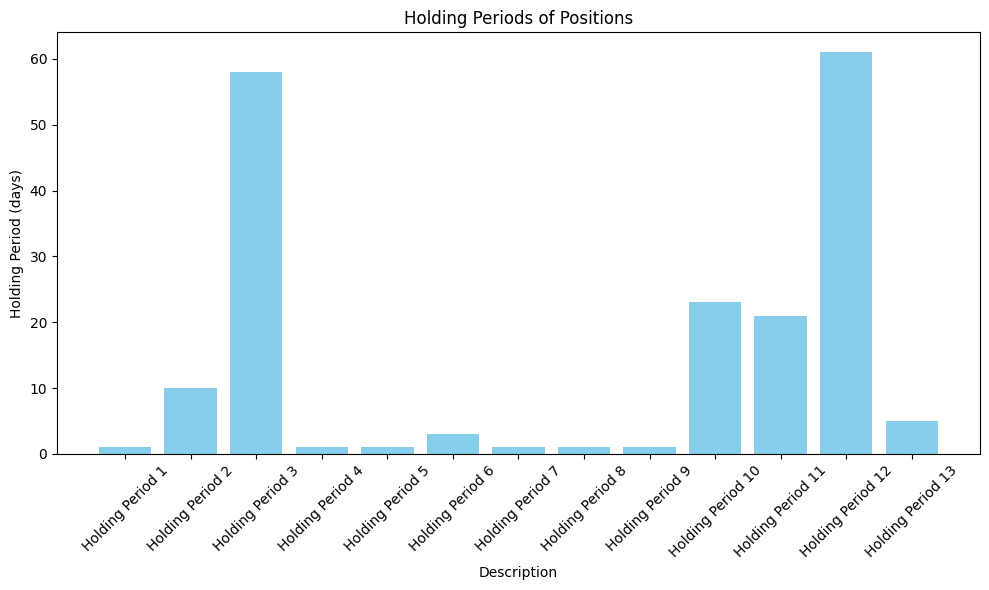

In [16]:
# Find all open and close position indices
open_positions = df[df['action'].str.contains('Open')]
close_positions = df[df['action'].str.contains('Close')]

# Initialize holding days list
holding_days = []

# Check if each open trade has a corresponding close trade
for idx, open_row in open_positions.iterrows():
    close_row = close_positions[(close_positions['date'] > open_row['date']) & (close_positions['action'] == open_row['action'].replace('Open', 'Close'))]
    if not close_row.empty:
        close_date = close_row.iloc[0]['date']
        holding_days.append((close_date - open_row['date']).days)
    else:
        print(f"Warning: No close found for open date {open_row['date']}")

# Calculate average holding days
if holding_days:
    average_holding_days = sum(holding_days) / len(holding_days)
else:
    average_holding_days = 0

print(f"Average Holding Days: {average_holding_days:.2f}")

holding_days_df = pd.DataFrame({
    'Holding Period (days)': holding_days,
    'Description': ['Holding Period ' + str(i+1) for i in range(len(holding_days))]
})

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(holding_days_df['Description'], holding_days_df['Holding Period (days)'], color='skyblue')
plt.xlabel('Description')
plt.ylabel('Holding Period (days)')
plt.title('Holding Periods of Positions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



open signal analysis

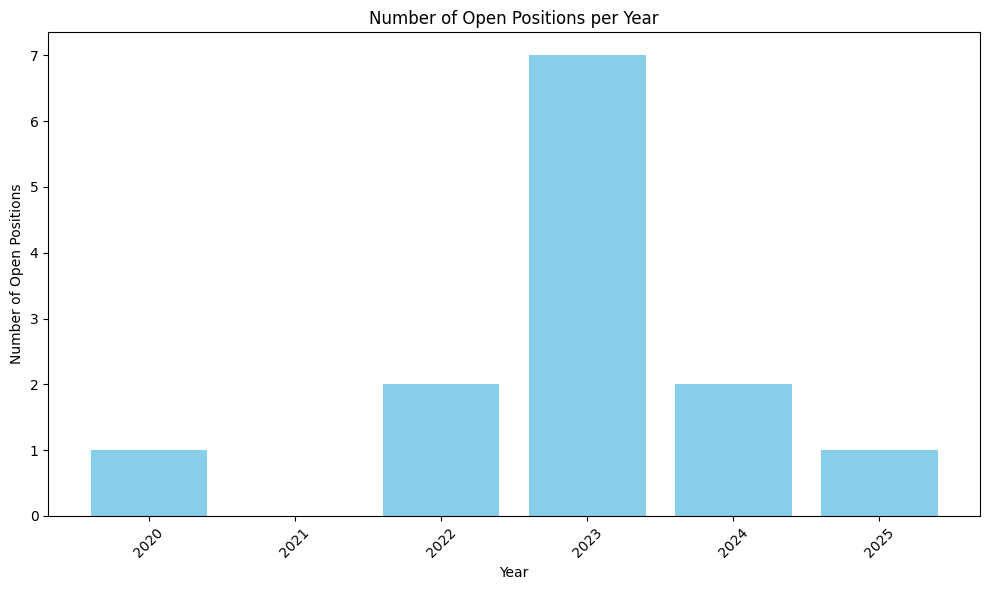

In [17]:
df['date'] = pd.to_datetime(df['date'])

# Find all open position records
open_positions = df[df['action'].str.contains('Open')]

# Count open positions by year
open_counts = open_positions['date'].dt.year.value_counts().sort_index()

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(open_counts.index, open_counts.values, color='skyblue')
plt.xlabel('Year')
plt.ylabel('Number of Open Positions')
plt.title('Number of Open Positions per Year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()